Epoch 1, Train Loss: 0.3227, Test Loss: 0.1442
Epoch 2, Train Loss: 0.1911, Test Loss: 0.0641
Epoch 3, Train Loss: 0.0997, Test Loss: 0.0173
Epoch 4, Train Loss: 0.0400, Test Loss: 0.0076
Epoch 5, Train Loss: 0.0177, Test Loss: 0.0335
Epoch 6, Train Loss: 0.0323, Test Loss: 0.0659
Epoch 7, Train Loss: 0.0577, Test Loss: 0.0772
Epoch 8, Train Loss: 0.0669, Test Loss: 0.0676
Epoch 9, Train Loss: 0.0589, Test Loss: 0.0491
Epoch 10, Train Loss: 0.0438, Test Loss: 0.0309
Epoch 11, Train Loss: 0.0298, Test Loss: 0.0170
Epoch 12, Train Loss: 0.0205, Test Loss: 0.0091
Epoch 13, Train Loss: 0.0169, Test Loss: 0.0063
Epoch 14, Train Loss: 0.0178, Test Loss: 0.0065
Epoch 15, Train Loss: 0.0211, Test Loss: 0.0081
Epoch 16, Train Loss: 0.0247, Test Loss: 0.0096
Epoch 17, Train Loss: 0.0275, Test Loss: 0.0102
Epoch 18, Train Loss: 0.0287, Test Loss: 0.0100
Epoch 19, Train Loss: 0.0285, Test Loss: 0.0092
Epoch 20, Train Loss: 0.0270, Test Loss: 0.0080
Epoch 21, Train Loss: 0.0246, Test Loss: 0.0068
E

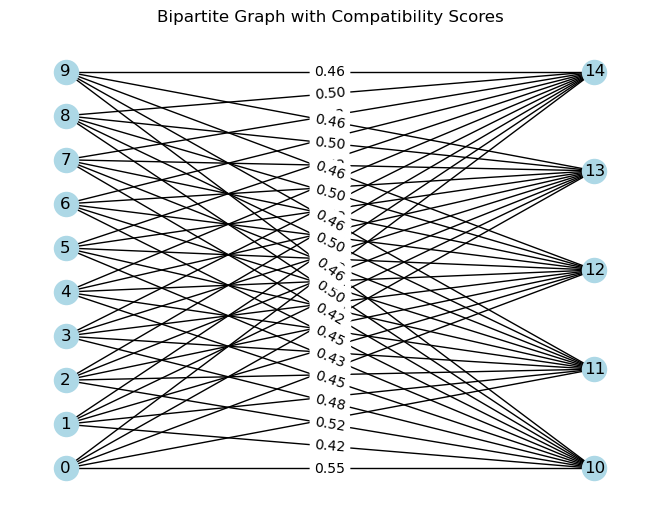

In [6]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, global_mean_pool

# Step 1: Generate Synthetic Data
np.random.seed(42)
n_resumes = 10
n_jobs = 5

# Example features: skill match percentage, experience match, soft skill compatibility
resume_features = np.random.rand(n_resumes, 3)  # Skill, Experience, Cultural Fit
job_features = np.array([[0.7, 0.2, 0.1],  # Job X priorities
                         [0.3, 0.3, 0.4],  # Job Y priorities
                         [0.5, 0.4, 0.1],
                         [0.4, 0.5, 0.1],
                         [0.2, 0.6, 0.2]])  # Random other jobs

# Compatibility heuristic with nuanced scoring (weighted dot product)
edge_weights = np.zeros((n_resumes, n_jobs))

for i in range(n_resumes):
    for j in range(n_jobs):
        edge_weights[i, j] = np.dot(resume_features[i], job_features[j])  # Weighted match

# Step 2: Create Bipartite Graph
graph_edges = []
edge_weights_list = []

for i in range(n_resumes):
    for j in range(n_jobs):
        graph_edges.append((i, n_resumes + j))  # Bipartite edges
        edge_weights_list.append(edge_weights[i, j])

edge_index = torch.tensor(graph_edges, dtype=torch.long).t().contiguous()
edge_attr = torch.tensor(edge_weights_list, dtype=torch.float)

# Node features
x_resumes = torch.tensor(resume_features, dtype=torch.float)
x_jobs = torch.tensor(job_features, dtype=torch.float)
x = torch.cat([x_resumes, x_jobs], dim=0)

# Step 3: Adjusted GNN Model for Edge Predictions
class GNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc_edge = nn.Linear(2 * hidden_dim, 1)  # For edge-level predictions

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        
        # Generate edge-level embeddings
        edge_src, edge_tgt = edge_index
        edge_embeddings = torch.cat([x[edge_src], x[edge_tgt]], dim=-1)
        edge_scores = self.fc_edge(edge_embeddings)
        return edge_scores

# Step 4: Updated Model and Data
model = GNNModel(input_dim=3, hidden_dim=16)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Training and Testing Split
num_edges = edge_index.size(1)
train_edges, test_edges = train_test_split(range(num_edges), test_size=0.2, random_state=42)
train_mask = torch.zeros(num_edges, dtype=torch.bool)
train_mask[train_edges] = True

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index).squeeze()  # Get edge predictions
    train_loss = criterion(out[train_mask], data.edge_attr[train_mask])
    train_loss.backward()
    optimizer.step()
    return train_loss.item()

def test():
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index).squeeze()  # Get edge predictions
        test_loss = criterion(out[~train_mask], data.edge_attr[~train_mask])
    return test_loss.item()

# Training Loop
for epoch in range(50):
    train_loss = train()
    test_loss = test()
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

# Step 5: Proof-of-Concept
# Step 5: Proof-of-Concept: Sample Compatibility Scores
sample_resumes = {
    "Resume A": [0.6, 0.9, 0.3],  # Average skill, high experience, low cultural fit
    "Resume B": [0.8, 0.6, 0.7],  # High skill, moderate experience, high cultural fit
}
sample_jobs = {
    "Job X": [0.7, 0.2, 0.1],  # Prefers skill > experience > cultural fit
    "Job Y": [0.3, 0.3, 0.4],  # Prefers cultural fit > skill > experience
}

print("\nSample Proof of Concept:")
for resume_name, resume_features in sample_resumes.items():
    for job_name, job_priorities in sample_jobs.items():
        compatibility = np.dot(resume_features, job_priorities)
        print(f"Compatibility of {resume_name} with {job_name}: {compatibility:.2f}")

print("\nSample Proof of Concept:")
for resume_name, resume_features in sample_resumes.items():
    for job_name, job_priorities in sample_jobs.items():
        compatibility = np.dot(resume_features, job_priorities)
        print(f"Compatibility of {resume_name} with {job_name}: {compatibility:.2f}")

# Step 6: Visualization
final_scores = model(data.x, data.edge_index).squeeze().detach().numpy()

B = nx.Graph()

# Add nodes
for i in range(n_resumes):
    B.add_node(i, bipartite=0, label=f"Resume {i+1}")
for j in range(n_jobs):
    B.add_node(n_resumes + j, bipartite=1, label=f"Job {j+1}")

# Add edges with final scores as weights
for idx, (src, tgt) in enumerate(graph_edges):
    B.add_edge(src, tgt, weight=final_scores[idx])

pos = nx.drawing.layout.bipartite_layout(B, nodes=[i for i in range(n_resumes)])
nx.draw(B, pos, with_labels=True, node_color="lightblue")
labels = nx.get_edge_attributes(B, 'weight')
nx.draw_networkx_edge_labels(B, pos, edge_labels={k: f"{v:.2f}" for k, v in labels.items()})
plt.title("Bipartite Graph with Compatibility Scores")
plt.show()

